#**Unsupervised pre-training vs Data Augmentation**

*Students:* --Valentina Barletta (Deep Learning) valentina.barletta@edu.unito.it --Sara De Benedetti (Reti Neurali) sara.debenedetti493@edu.unito.it

# Encoder with Softmax


Importing Modules

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
from statistics import mean
import numpy as np

from torchsummary import summary
from tqdm import tqdm

import os
import time

#path_data = 'MyDrive/Progetto Deep/Data/'
#model_path = '/content/drive/MyDrive/Progetto Deep/Data/model.pth'
#model_path = '/content/drive/MyDrive/Progetto Deep/Data/model_sparse.pth'


#from google.colab import drive
#drive.mount('/content/drive')

#subject = 'EncoderWithSoftmax'

Get the computation device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cpu


## Our net: Pretrained Convolutional Encoder with Softmax

 Here it's represented the architecture of our Convolutional Autoencoder Neural Network pretrained.

In [3]:
input_dim = (28 * 28)
hidden_dim = 10
out_dim = 10

class Autoencoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


        # Decoder
        self.decoder = nn. Sequential(nn.Conv2d(4, 4, kernel_size=3, padding=1),  # 7 x 7 x 4 -> 7 x 7 x 4
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 7 x 7 x 4 -> 14 x 14 x 4
                                      nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 14 x 14 x 4 -> 14 x 14 x 8
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 14 x 14 x 8 -> 28 x 28 x 8
                                      nn.Conv2d(8, 1, kernel_size=3, padding=1))  # 28 x 28 x 8 -> 28 x 28 x 1


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


pret_autoenc = Autoencoder(input_dim, out_dim).to(device)

Restoring the model

In [4]:
pret_autoenc.load_state_dict(torch.load("model.pth"))
# pretrained_autoencoder.eval()

<All keys matched successfully>

In this section, we will define our neural network made by our pretrained encoder combined with a softmax layer.

In [5]:
class EncoderWithSoftmax(nn.Module):
    def __init__(self, pretrained_autoencoder):
        super(EncoderWithSoftmax, self).__init__()

        # Extraction of the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder
        
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add the softmax layer
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=4 * 7 * 7, out_features=10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [6]:
temp = EncoderWithSoftmax(pret_autoenc)
summary(temp, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             292
              ReLU-5            [-1, 4, 14, 14]               0
         MaxPool2d-6              [-1, 4, 7, 7]               0
           Flatten-7                  [-1, 196]               0
            Linear-8                   [-1, 10]           1,970
           Softmax-9                   [-1, 10]               0
Total params: 2,342
Trainable params: 1,970
Non-trainable params: 372
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.01
Estimated Total Size (MB): 0.13
---------------------------------------------

## Some Helper Functions

In [7]:
def accuracy(y_pred, y):

    pred = y_pred.detach().argmax(dim=1)
    corrects = (pred == y)
    accuracy = (corrects.sum()/corrects.size(0)).float()

    return accuracy


def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

    acc_train, acc_test = 0, 0
    running_loss = 0.0

    with torch.no_grad():

        for x_train, y_train in train_loader:

            x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

            out = model(x_train).squeeze()
            acc_train += accuracy(out, y_train)

        for x_test, y_test in test_loader:

            x_test, y_test = x_test.to(device), y_test.to(device)

            out = model(x_test).squeeze()
            loss = loss_function(out, y_test)
            running_loss += loss.item()
            acc_test += accuracy(out, y_test)
            
        val_loss = running_loss / len(test_loader)
        acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

    return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100, val_loss


def train(model, x, y, loss_function, optimizer):
    model.train()
    out = model(x).squeeze()
    
    loss = loss_function(out, y)

    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()
    return float(loss)

**Loss Function and Optimizer**

For the loss function, we will use `CrossEntropyLoss` (Cross Entropy Loss).
The optimizer is going to be `SGD` with a learning rate of 0.01.

In [8]:
loss_function = nn.CrossEntropyLoss()

Prepare the Data

In [9]:
n_train = 8000
n_test = 350

batch_size_train = 16
batch_size_test = 32

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[n_train:(n_train + n_test)], dataset_test.targets[n_train:(n_train + n_test)]
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)

Since we want to derive how the accuracy changes as the size of the training dataset decreases, here there is the code which trains a neural network on the MNIST dataset, adjusting the size of the training dataset and batch size dynamically for each iteration of the loop, and it monitors the training process using early stopping to prevent overfitting.



In [10]:
old_acc = []
old_train = []
old_test = []

ratio = 50
EPOCHS = 100
n_runs = 3

for j in range(n_runs):
    
    ACCURACY_matrix = []
    TrainLOSS_matrix = []
    TestLOSS_matrix = []
    
    print(f"Run Number: {j+1}")
    
    for i in range (1, ratio+1):

        train_losses = []
        test_losses = []
        test_accuracies = []

        # Set the datasetsize
        n_train_loop = int(n_train * i / ratio)
        #batch_size_train_loop = int(batch_size_train * i / ratio)

        # Create the train dataset and the train loader 
        dataset_train =  torchvision.datasets.MNIST('./files/', train = False, download = True, transform = transform)
        dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle = True, drop_last = True)

        # Call our Net
        model = EncoderWithSoftmax(pret_autoenc).to(device)

        #Set the Optimazer
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

        for epoch in range(1,EPOCHS+1):
            train_loss = 0

            for x_train, y_train in train_loader:
                x_train, y_train = x_train.to(device), y_train.to(device)
                loss = train(model, x_train, y_train, loss_function, optimizer)
                train_loss += loss

            train_loss /= len(train_loader)                    # we divide by the number of batches
            train_losses.append(train_loss)

            train_acc, test_acc, test_loss = evaluate(model, train_loader, test_loader)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)

            if epoch % 25 == 0:
                print("Epoch:", epoch, "Loss:", float(train_loss), "Test Loss:", test_loss, "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

        # Save in ACCURACY_matrix
        ACCURACY_matrix.append(test_accuracies)
        TrainLOSS_matrix.append(train_losses)
        TestLOSS_matrix.append(test_losses)

    if j == 0:

        old_acc = ACCURACY_matrix
        old_train = TrainLOSS_matrix
        old_test = TestLOSS_matrix

    else:

        # For old_acc and ACCURACY_matrix
        old_acc = [[old_acc[row][col] + ACCURACY_matrix[row][col] for col in range(len(old_acc[0]))] for row in range(len(old_acc))]

        # For old_train and TrainLOSS_matrix
        old_train = [[old_train[row][col] + TrainLOSS_matrix[row][col] for col in range(len(old_train[0]))] for row in range(len(old_train))]

        # For old_test and TestLOSS_matrix
        old_test = [[old_test[row][col] + TestLOSS_matrix[row][col] for col in range(len(old_test[0]))] for row in range(len(old_test))]
        

    print("\n")

Run Number: 1
Epoch: 25 Loss: 1.6669313788414002 Test Loss: 1.8744245659221301 data: 160 train_acc 84.375 test_acc 62.82196640968323
Epoch: 50 Loss: 1.537372100353241 Test Loss: 1.7791441895745017 data: 160 train_acc 95.6250011920929 test_acc 73.40908646583557
Epoch: 75 Loss: 1.5158204197883607 Test Loss: 1.7589259364388206 data: 160 train_acc 96.24999761581421 test_acc 74.28030371665955
Epoch: 100 Loss: 1.5085623264312744 Test Loss: 1.7460658767006614 data: 160 train_acc 96.24999761581421 test_acc 75.1325786113739
Epoch: 25 Loss: 1.603772485256195 Test Loss: 1.7772120995955034 data: 320 train_acc 91.25000238418579 test_acc 72.89772629737854
Epoch: 50 Loss: 1.5511335015296936 Test Loss: 1.7459059736945413 data: 320 train_acc 93.4374988079071 test_acc 73.44696521759033
Epoch: 75 Loss: 1.5369155824184417 Test Loss: 1.7411377755078403 data: 320 train_acc 93.4374988079071 test_acc 74.29924011230469
Epoch: 100 Loss: 1.5317798554897308 Test Loss: 1.7371496720747515 data: 320 train_acc 93.437

Epoch: 25 Loss: 1.5506893087835874 Test Loss: 1.6067634387449785 data: 2720 train_acc 93.52940917015076 test_acc 87.12120652198792
Epoch: 50 Loss: 1.5233416599385878 Test Loss: 1.5967160680077293 data: 2720 train_acc 95.40441036224365 test_acc 87.12120652198792
Epoch: 75 Loss: 1.510690804088817 Test Loss: 1.5910917412150989 data: 2720 train_acc 96.36029601097107 test_acc 88.25757503509521
Epoch: 100 Loss: 1.5041782280978035 Test Loss: 1.5895080999894575 data: 2720 train_acc 96.65440917015076 test_acc 88.27651739120483
Epoch: 25 Loss: 1.599470947848426 Test Loss: 1.6127549843354658 data: 2880 train_acc 92.39583611488342 test_acc 87.12120652198792
Epoch: 50 Loss: 1.5242646992206574 Test Loss: 1.607180042700334 data: 2880 train_acc 95.59027552604675 test_acc 86.26893758773804
Epoch: 75 Loss: 1.5114712218443553 Test Loss: 1.6022266908125444 data: 2880 train_acc 96.42361402511597 test_acc 86.26893758773804
Epoch: 100 Loss: 1.503973580731286 Test Loss: 1.6047359921715476 data: 2880 train_acc

Epoch: 100 Loss: 1.5102178383618594 Test Loss: 1.5773521119898015 data: 5120 train_acc 95.99609375 test_acc 89.41287994384766
Epoch: 25 Loss: 1.5428369092218803 Test Loss: 1.5720297748392278 data: 5280 train_acc 93.67424249649048 test_acc 89.41287994384766
Epoch: 50 Loss: 1.5238717949751652 Test Loss: 1.571115179495378 data: 5280 train_acc 95.18939256668091 test_acc 89.12878632545471
Epoch: 75 Loss: 1.5145712581547823 Test Loss: 1.5855985771525989 data: 5280 train_acc 95.492422580719 test_acc 87.6893937587738
Epoch: 100 Loss: 1.5092698263399529 Test Loss: 1.575962023301558 data: 5280 train_acc 96.07954621315002 test_acc 88.54166269302368
Epoch: 25 Loss: 1.5436517038766076 Test Loss: 1.5704467621716587 data: 5440 train_acc 93.63970756530762 test_acc 89.98106122016907
Epoch: 50 Loss: 1.5232574319138246 Test Loss: 1.5785726633938877 data: 5440 train_acc 95.14706134796143 test_acc 88.5606050491333
Epoch: 75 Loss: 1.5141775243422564 Test Loss: 1.5726203918457031 data: 5440 train_acc 95.4779

Epoch: 75 Loss: 1.5106760062277318 Test Loss: 1.5407308556816794 data: 7680 train_acc 95.96354365348816 test_acc 92.51893758773804
Epoch: 100 Loss: 1.506915490080913 Test Loss: 1.5426910682158037 data: 7680 train_acc 96.10677361488342 test_acc 91.66666269302368
Epoch: 25 Loss: 1.5311108182887643 Test Loss: 1.5327557000246914 data: 7840 train_acc 94.51530575752258 test_acc 93.69317889213562
Epoch: 50 Loss: 1.5160573599289875 Test Loss: 1.5400347167795354 data: 7840 train_acc 95.65051198005676 test_acc 92.25378632545471
Epoch: 75 Loss: 1.5099325026784625 Test Loss: 1.545990521257574 data: 7840 train_acc 95.95663547515869 test_acc 91.95075631141663
Epoch: 100 Loss: 1.5058751446860177 Test Loss: 1.5416871309280396 data: 7840 train_acc 96.27550840377808 test_acc 92.23484396934509
Epoch: 25 Loss: 1.5322719407081604 Test Loss: 1.537913820960305 data: 8000 train_acc 94.38750147819519 test_acc 93.10606122016907
Epoch: 50 Loss: 1.517975878238678 Test Loss: 1.5379488576542248 data: 8000 train_acc

Epoch: 75 Loss: 1.5132514272417341 Test Loss: 1.6046030738136985 data: 2240 train_acc 96.11607193946838 test_acc 86.2500011920929
Epoch: 100 Loss: 1.5059974551200868 Test Loss: 1.615074341947382 data: 2240 train_acc 96.51785492897034 test_acc 85.07575988769531
Epoch: 25 Loss: 1.5526282596588135 Test Loss: 1.6011957905509255 data: 2400 train_acc 92.83333420753479 test_acc 87.12120652198792
Epoch: 50 Loss: 1.5266343808174134 Test Loss: 1.6161500432274558 data: 2400 train_acc 95.24999856948853 test_acc 85.98484396934509
Epoch: 75 Loss: 1.5145028638839722 Test Loss: 1.5931744900616733 data: 2400 train_acc 96.04166746139526 test_acc 87.97348141670227
Epoch: 100 Loss: 1.50767139116923 Test Loss: 1.587422717701305 data: 2400 train_acc 96.45833373069763 test_acc 88.25757503509521
Epoch: 25 Loss: 1.5515351183712482 Test Loss: 1.6032554236325351 data: 2560 train_acc 93.75 test_acc 86.83711886405945
Epoch: 50 Loss: 1.524398473650217 Test Loss: 1.597623727538369 data: 2560 train_acc 95.35156488418

Epoch: 50 Loss: 1.5406558505694072 Test Loss: 1.5929964238947087 data: 4800 train_acc 94.0625011920929 test_acc 87.99242377281189
Epoch: 75 Loss: 1.5193011558055878 Test Loss: 1.5950008739124646 data: 4800 train_acc 95.6250011920929 test_acc 86.83711886405945
Epoch: 100 Loss: 1.511958944797516 Test Loss: 1.5950867154381492 data: 4800 train_acc 95.99999785423279 test_acc 86.83711886405945
Epoch: 25 Loss: 1.5439508115091631 Test Loss: 1.6004719842563977 data: 4960 train_acc 93.46774220466614 test_acc 86.26893758773804
Epoch: 50 Loss: 1.5255404399287316 Test Loss: 1.5880530314012007 data: 4960 train_acc 95.20161151885986 test_acc 87.40530014038086
Epoch: 75 Loss: 1.515773364036314 Test Loss: 1.5839419690045444 data: 4960 train_acc 95.72580456733704 test_acc 87.99242377281189
Epoch: 100 Loss: 1.5096641102144794 Test Loss: 1.5739627968181262 data: 4960 train_acc 96.088707447052 test_acc 89.10984396934509
Epoch: 25 Loss: 1.5434849474579095 Test Loss: 1.5808636817065151 data: 5120 train_acc 9

Epoch: 25 Loss: 1.5330552686815677 Test Loss: 1.5412793918089434 data: 7360 train_acc 94.361412525177 test_acc 92.25378632545471
Epoch: 50 Loss: 1.5188223540782928 Test Loss: 1.5455810156735508 data: 7360 train_acc 95.4211950302124 test_acc 91.66666269302368
Epoch: 75 Loss: 1.512328666448593 Test Loss: 1.5485885034907947 data: 7360 train_acc 95.8152174949646 test_acc 91.66666269302368
Epoch: 100 Loss: 1.5073744872341985 Test Loss: 1.5536714358763262 data: 7360 train_acc 95.923912525177 test_acc 91.09848141670227
Epoch: 25 Loss: 1.5324201036006846 Test Loss: 1.548732800917192 data: 7520 train_acc 93.85638236999512 test_acc 91.40151739120483
Epoch: 50 Loss: 1.517694360144595 Test Loss: 1.538182963024486 data: 7520 train_acc 95.37234306335449 test_acc 93.10606122016907
Epoch: 75 Loss: 1.5114141137041943 Test Loss: 1.5415760387073865 data: 7520 train_acc 95.98404169082642 test_acc 92.51893758773804
Epoch: 100 Loss: 1.5072671286603239 Test Loss: 1.5434614203192971 data: 7520 train_acc 96.03

Epoch: 25 Loss: 1.620465103785197 Test Loss: 1.6945567564530806 data: 1920 train_acc 86.71875 test_acc 77.42424011230469
Epoch: 50 Loss: 1.5984220365683237 Test Loss: 1.6927313912998547 data: 1920 train_acc 87.60416507720947 test_acc 77.4431824684143
Epoch: 75 Loss: 1.5878403415282567 Test Loss: 1.6955481334166094 data: 1920 train_acc 88.02083134651184 test_acc 76.57196521759033
Epoch: 100 Loss: 1.581860210498174 Test Loss: 1.6932199001312256 data: 1920 train_acc 88.28125 test_acc 76.83712244033813
Epoch: 25 Loss: 1.5510775208473206 Test Loss: 1.6219808296723799 data: 2080 train_acc 93.41346025466919 test_acc 85.4356050491333
Epoch: 50 Loss: 1.524474119223081 Test Loss: 1.6210204579613425 data: 2080 train_acc 95.67307829856873 test_acc 84.5643937587738
Epoch: 75 Loss: 1.5112146707681509 Test Loss: 1.62433321909471 data: 2080 train_acc 96.44230604171753 test_acc 84.54545736312866
Epoch: 100 Loss: 1.5031330897257877 Test Loss: 1.6283021298321811 data: 2080 train_acc 96.58653736114502 tes

Epoch: 25 Loss: 1.5466457435062952 Test Loss: 1.5967440713535657 data: 4480 train_acc 93.08035969734192 test_acc 87.70833611488342
Epoch: 50 Loss: 1.5258986094168254 Test Loss: 1.582923488183455 data: 4480 train_acc 94.64285969734192 test_acc 88.84469866752625
Epoch: 75 Loss: 1.5158284434250422 Test Loss: 1.5686385414817117 data: 4480 train_acc 95.73660492897034 test_acc 90.26515483856201
Epoch: 100 Loss: 1.5094304804291043 Test Loss: 1.57021118294109 data: 4480 train_acc 95.89285850524902 test_acc 90.26515483856201
Epoch: 25 Loss: 1.5445715049217488 Test Loss: 1.6028983376242898 data: 4640 train_acc 93.14655065536499 test_acc 85.98484396934509
Epoch: 50 Loss: 1.5249545072687083 Test Loss: 1.5859112631190906 data: 4640 train_acc 95.28017044067383 test_acc 88.27651739120483
Epoch: 75 Loss: 1.5147971017607327 Test Loss: 1.5866449637846514 data: 4640 train_acc 95.79741358757019 test_acc 87.14015483856201
Epoch: 100 Loss: 1.5090157118336909 Test Loss: 1.5718814026225696 data: 4640 train_ac

Epoch: 25 Loss: 1.6220725094730204 Test Loss: 1.6601844809272073 data: 7040 train_acc 84.94318127632141 test_acc 80.24621605873108
Epoch: 50 Loss: 1.609115116433664 Test Loss: 1.6420467008243909 data: 7040 train_acc 86.15056872367859 test_acc 82.53787755966187
Epoch: 75 Loss: 1.6026584099639545 Test Loss: 1.638939088041132 data: 7040 train_acc 86.63352131843567 test_acc 82.51894116401672
Epoch: 100 Loss: 1.5980907797813415 Test Loss: 1.6476856144991787 data: 7040 train_acc 86.6193175315857 test_acc 81.40151500701904
Epoch: 25 Loss: 1.5334383281071982 Test Loss: 1.5477654283696956 data: 7200 train_acc 94.26388740539551 test_acc 91.96969866752625
Epoch: 50 Loss: 1.518884773519304 Test Loss: 1.5509691021659158 data: 7200 train_acc 95.30555605888367 test_acc 91.66666269302368
Epoch: 75 Loss: 1.5113530066278247 Test Loss: 1.5433721542358398 data: 7200 train_acc 95.91666460037231 test_acc 92.23484396934509
Epoch: 100 Loss: 1.5077842169337803 Test Loss: 1.5495551282709294 data: 7200 train_acc

Implement the average

In [11]:
ACCURACY_matrix = [[element / n_runs for element in row] for row in old_acc]
TrainLOSS_matrix = [[element / n_runs for element in row] for row in old_train]
TestLOSS_matrix = [[element / n_runs for element in row] for row in old_test]

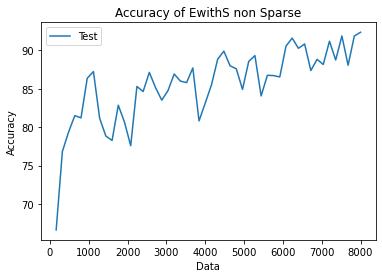

In [12]:
last_elements = [sublist[-1] for sublist in ACCURACY_matrix]

# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]

# Plot the values
plt.plot(data, last_elements, label = "Test")
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of EwithS non Sparse')
plt.legend()
plt.show()

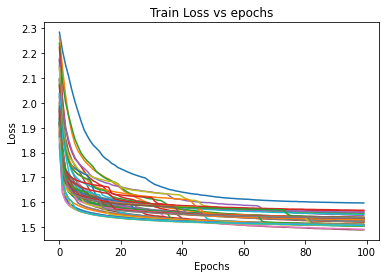

In [13]:
for i in range(len(TrainLOSS_matrix)):
    plt.plot(range(EPOCHS), TrainLOSS_matrix[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs epochs')
plt.show()

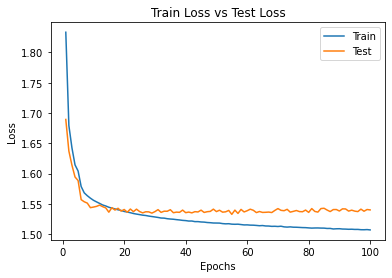

In [14]:
plt.plot(range(1, EPOCHS + 1), TrainLOSS_matrix[-1], label = "Train")
plt.plot(range(1, EPOCHS + 1), TestLOSS_matrix[-1], label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

*Salvataggio dei dati*

In [15]:
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

file_name1 = 'TrainLOSS_matrix_MNIST_normal.npy'
np.save(os.path.join(result_dir, file_name1), TrainLOSS_matrix)

file_name2 = 'ACCURACY_matrix_MNIST_normal.npy'
np.save(os.path.join(result_dir, file_name2), ACCURACY_matrix)

file_name3 = 'TestLOSS_matrix_MNIST_normal.npy'
np.save(os.path.join(result_dir, file_name3), TestLOSS_matrix)

**Confusion Matrix**

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.95 0.   0.   0.   0.   0.   0.03 0.03 0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.   0.   0.03 0.  ]
 [0.03 0.   0.75 0.   0.17 0.   0.   0.   0.06 0.  ]
 [0.03 0.   0.   0.83 0.   0.   0.   0.   0.14 0.  ]
 [0.   0.   0.   0.   0.92 0.   0.05 0.   0.   0.03]
 [0.   0.   0.   0.   0.   0.96 0.   0.   0.04 0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.06 0.03 0.   0.91 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.09 0.   0.91]]


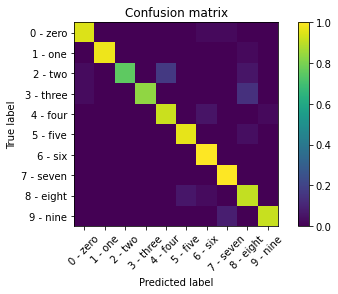

In [17]:
classes =dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

# Prova

In [18]:
n_train = 2000
n_test = 500

batch_size_train = 32
batch_size_test = n_test

dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train, shuffle = True,  drop_last = True)

EPOCHS = 100

train_losses = []
train_accuracies = []
test_accuracies = []

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(EPOCHS):

    train_loss = 0

  ## TRAIN STEP

    for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        loss = train(model, x_train, y_train)
        train_loss += loss

    train_loss /= len(train_loader)                    # we divide by the number of batches
    train_losses.append(train_loss)

  ## TEST STEP

    if epoch % 10 == 0:

        train_acc, test_acc = evaluate(model, train_loader, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print("Epoch:", epoch, "Loss:", float(train_loss), "train_acc:", train_acc, "test_acc:", test_acc)


TypeError: train() missing 2 required positional arguments: 'loss_function' and 'optimizer'

In [ ]:
epochs = [i*10 for i in range(EPOCHS//10)]

plt.plot(epochs, train_accuracies, label = "Train")
plt.plot(epochs, test_accuracies, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.legend()

plt.show()